In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 
from scipy.optimize import minimize

In [2]:
class Dish:
    def __init__(self, f, dphi, r0, r1):
        self.set_params(f, dphi, r0, r1)
    def set_params(self, f, dphi, r0, r1):
        f = 290
        r0 = 70
        r1 = 100
        ## petal from center, upring
        points_pet = [ (4,4), (5,3), (5,2), (5,1), (0,1), (-5,1), (-5,2), (-5,3), (-4,4)]
        dphi_rad = dphi/180*np.pi
        def get_point ( petal, upright, f):
            r = r0+(upright-1)*r1
            x = r*np.sin(dphi_rad*petal)
            y = r*np.cos(dphi_rad*petal)
            z = r*r/(4*np.abs(f))
            #print (r,x,y,z,dphi_rad, petal, upright)
            #stop()
            return np.array([x,y,z])
        points_xyz = [get_point(petal, upright,f) for petal,upright in points_pet]
        self.points_xyz = points_xyz
        self.focal = np.array([0,0,f])
        self.dishcenter = get_point(0,3,f)

class Horn:
    def __init__(self, Dish, alpha, beta, gamma, xp, yp, zp):
        self.Dish = Dish
        self.set_params(alpha,beta,gamma, xp, yp, zp )
    def set_params(self,alpha,beta,gamma, xp, yp, zp):
        dh = 69.0
        dv = 69.1
        ## lookin down from the focal point
        p1 = np.array([-dh/2,+dv/2,0]) #corners of the horn
        p2 = np.array([+dh/2,+dv/2,0])
        p3 = np.array([+dh/2,-dv/2,0])
        p4 = np.array([-dh/2,-dv/2,0])
        R = Rotation.from_euler('zyx',[alpha,beta,gamma],degrees=True).as_matrix()   # rotates it by an angle
        ofs = np.array([xp,yp,zp])
        points_pxyz = [np.dot(R,p)+ofs for p in [p1,p2,p3,p4]]
        # points_pxyz is in the coordinate system looking down from the focal 
        # point of the dish at the center of the dish surface
        # we now need to transform this to the dish coordinate system
        znormal = self.Dish.dishcenter-self.Dish.focal
        znormal /= np.sqrt((znormal**2).sum())
        xnormal = np.array([1,0,0])
        ynormal = np.cross(xnormal,znormal)
#         print (xnormal, ynormal, znormal)
        points_xyz = [self.Dish.focal+v[0]*xnormal+v[1]*ynormal+v[2]*znormal for v in points_pxyz]
#         print (points_xyz)
        self.points = points_xyz
        
class Fitter:
    def __init__(self, data, vec):
        self.data = data
        self.vec = vec
        
    def predict_measurements(self, vec):
        D = Dish(*vec[:4])
        pD = D.points_xyz
        H = Horn(D, *vec[4:])
        pH = H.points
        def dist(p1,p2):
            return np.sqrt(np.sum((p1-p2)**2))
        pred = np.array([[dist(p1,p2) for p1 in pH] for p2 in pD])
        return pred
        
    def chi2(self, vec):
        pred = self.predict_measurements(vec)
        dchisq = (pred-self.data)**2/sigma**2
        dchisq[self.data  < 0] = 0.0 # negative numbers won't add to chi2
        chisq = dchisq.sum()
        return chisq

    def fit(self):
        fit_min = minimize(self.chi2, self.vec)
        return fit_min

In [3]:
N_measurements = np.array([
    [376.6, 337.0, 353.2, 390.8],
    [331.3, 291.8, 284.1, 324.1],
    [296.7, 269.2, 240.1, 269.5],
    [282.3, 271.1, 222.5, 235.6],    
    [272.5, 272.7, 228.3, 227.9],
    [270.0, 282.0, 236.5, 221.7],
    [266.7, 293.8, 269.4, 238.3],
    [288.3, 327.1, 323.1, 283.3],
    [333.7, 372.1, 389.4, 353.0]
])

In [4]:
# f, dphi, r0, r1, alpha, beta, gamma, xp, yp, zp
start = np.array([290., 8., 70., 100., 0, 0, 0, 0, 0, 20])
sigma = 0.3 ## sigma err in cm

N_fitter = Fitter(N_measurements, start)
N_fit = N_fitter.fit()
N_fit.fun

55.14333272030952

In [5]:
N_fitter.predict_measurements(N_fit.x)

array([[376.21886788, 336.69024119, 352.82163295, 390.72166911],
       [331.27287916, 291.95548044, 284.31186664, 324.55655196],
       [296.60896998, 269.83444017, 240.28802521, 270.00850178],
       [281.97644756, 271.34822956, 222.80708079, 235.63499432],
       [271.85454455, 272.51042822, 228.15078124, 227.36696965],
       [269.509333  , 281.6656282 , 236.10248091, 221.45910674],
       [266.98200814, 294.39300044, 269.3621862 , 239.09860166],
       [288.48254724, 327.48368715, 323.0590594 , 283.44976729],
       [333.99052885, 371.81807872, 388.7127811 , 352.70187963]])

Text(0, 0.5, 'residuals [cm]')

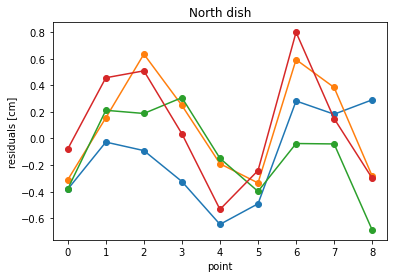

In [6]:
plt.plot(N_fitter.predict_measurements(N_fit.x)-N_measurements,'-o')
plt.title('North dish')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [7]:
vals = N_fit.x
errs=np.sqrt((N_fit.hess_inv.diagonal())*2)
names = 'f dphi r0 r1 alpha beta gamma xp yp zp'.split()
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

f = 290.00 +/- 1.41
dphi = 8.13 +/- 0.03
r0 = 70.00 +/- 1.41
r1 = 100.00 +/- 1.41
alpha = 1.80 +/- 0.13
beta = -0.10 +/- 0.15
gamma = 2.53 +/- 0.18
xp = -2.12 +/- 0.10
yp = -4.82 +/- 0.15
zp = 58.38 +/- 0.08


In [8]:
# E dish
E_measurements = np.array([
    [388.2, 348.8, 364.6, 401.6], 
    [341.5, 302.9, 296.0, 335.9], 
    [306.4, 278.4, 250.2, 280.9],
    [289.9, 276.8, 229.4, 245.1],
    [280.4, 277.8, 233.4, 235.7],
    [276.9, 286.0, 241.3, 229.9],
    [275.1, 299.1, 274.0, 247.1],
    [296.9, 332.4, 327.4, 291.3],
    [346.6, 381.9, 396.3, 362.7]
])

In [9]:
E_fitter = Fitter(E_measurements, start)
E_fit = E_fitter.fit()
E_fit.fun

260.6559650480857

In [10]:
E_fitter.predict_measurements(E_fit.x)

array([[387.96546207, 349.25574664, 365.08743957, 402.27659853],
       [341.91200052, 302.79975759, 295.93467377, 335.84736718],
       [306.20465414, 278.46555143, 250.15769298, 280.70820836],
       [289.25161818, 276.51393295, 228.99747702, 244.22610013],
       [279.92664754, 278.00275422, 234.06089301, 236.34275595],
       [276.48234968, 285.63706404, 240.14826156, 229.18364875],
       [276.07475169, 299.9969658 , 274.37850063, 247.99727949],
       [298.39534452, 333.87025664, 328.26112868, 292.10580612],
       [345.03603587, 379.89385375, 395.06485991, 361.67218509]])

Text(0, 0.5, 'residuals [cm]')

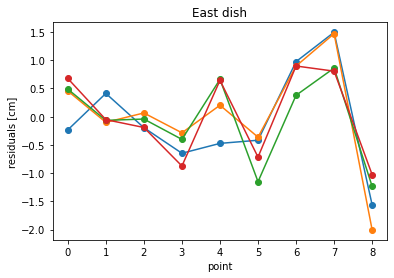

In [11]:
plt.plot(E_fitter.predict_measurements(E_fit.x)-E_measurements,'-o')
plt.title('East dish')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [12]:
vals = E_fit.x
errs=np.sqrt((E_fit.hess_inv.diagonal())*2)
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

f = 290.00 +/- 1.41
dphi = 7.95 +/- 0.03
r0 = 70.00 +/- 1.41
r1 = 100.00 +/- 1.41
alpha = 0.48 +/- 0.06
beta = -1.05 +/- 0.13
gamma = 0.95 +/- 0.03
xp = -5.56 +/- 0.12
yp = -7.69 +/- 0.15
zp = 46.17 +/- 0.07


In [13]:
# S dish
S_measurements = np.array([
    [384.2, 346.8, 365.9, 401.1],
    [337.5, 298.6, 295.5, 334.2],
    [302.0, 274.4, 249.9, 279.4],
    [285.3, 273.8, 229.6, 243.5],
    [276.0, 275.9, 235.4, 235.8],
    [274.2, 285.4, 243.0, 229.7],
    [275.1, 299.9, 278.9, 250.4],
    [298.7, 336.8, 334.0, 296.6],
    [347.7, 384.2, 401.3, 367.9]
])

In [14]:
S_fitter = Fitter(S_measurements, start)
S_fit = S_fitter.fit()
S_fit.fun

87.77433106748576

In [15]:
S_fitter.predict_measurements(S_fit.x)

array([[384.30992806, 346.37153948, 365.69226672, 401.81054165],
       [337.33728933, 298.95682473, 295.64978724, 334.41001842],
       [301.56809443, 274.84878509, 250.06529975, 279.16682298],
       [285.01660812, 273.60797837, 229.18499809, 242.69096487],
       [276.45089359, 276.12094114, 235.64819567, 236.03473167],
       [273.85423634, 284.72563182, 242.5342164 , 229.67434221],
       [275.30546636, 301.02636232, 278.97234531, 251.00159052],
       [299.55690506, 336.62717619, 334.21182585, 296.84007168],
       [347.13898105, 383.44091904, 401.46677551, 366.95245688]])

Text(0, 0.5, 'residuals [cm]')

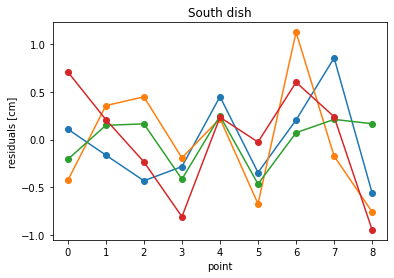

In [16]:
plt.plot(S_fitter.predict_measurements(S_fit.x)-S_measurements,'-o')
plt.title('South dish')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [17]:
vals = S_fit.x
errs=np.sqrt((S_fit.hess_inv.diagonal())*2)
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

f = 290.00 +/- 1.41
dphi = 8.02 +/- 0.06
r0 = 70.00 +/- 1.41
r1 = 100.00 +/- 1.41
alpha = 0.41 +/- 0.08
beta = -0.72 +/- 0.05
gamma = 3.84 +/- 0.04
xp = 0.16 +/- 0.09
yp = -10.49 +/- 0.06
zp = 45.23 +/- 0.05


In [18]:
# W dish
# numbers with minus in front of it don't contribute to chi2
W_measurements = np.array([
    [-378.1, 352.3, 371.9, 405.2],
    [-339.8, 301.7, 299.1, 336.2],
    [299.8, 273.5, 249.9, 278.1],
    [283.1, 270.8, 226.2, 241.0], # * Panel Damage
    [269.5, 269.3, 228.7, 229.9], # ** major panel-stanchion damage
    [269.9, 280.4, 237.3, 223.8],
    [271.2, 299.2, 274.7, 245.3],
    [298.0, 336.3, 332.4, 293.7],
    [348.4, 386.1, 401.4, 366.9]
])

In [19]:
W_fitter = Fitter(W_measurements, start)
W_fit = W_fitter.fit()
W_fit.fun

462.6843789349785

In [20]:
W_fitter.predict_measurements(W_fit.x)

array([[387.68774697, 352.20077228, 371.67951948, 405.46525173],
       [338.47863276, 301.52912072, 299.04401845, 336.26670838],
       [300.26350126, 273.9282704 , 249.80158208, 278.42827313],
       [281.17895141, 269.20061169, 224.6547319 , 238.87733661],
       [272.38396046, 271.85175448, 230.80734844, 231.43395946],
       [268.9763403 , 279.65281429, 236.4599164 , 223.73168566],
       [271.76159801, 298.27629658, 274.99248103, 245.98065305],
       [297.78097292, 336.22490537, 332.30084246, 293.3430939 ],
       [347.9095866 , 386.06925467, 402.33304716, 365.87360095]])

Text(0, 0.5, 'residuals [cm]')

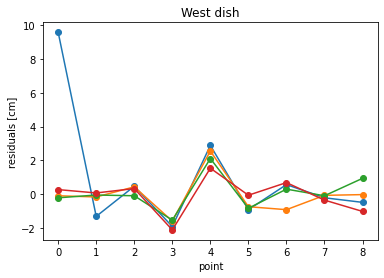

In [21]:
plt.plot(W_fitter.predict_measurements(W_fit.x)-np.abs(W_measurements),'-o')
plt.title('West dish')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [22]:
vals = W_fit.x
errs=np.sqrt((W_fit.hess_inv.diagonal())*2)
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

f = 290.00 +/- 1.41
dphi = 8.03 +/- 0.04
r0 = 70.00 +/- 1.41
r1 = 100.00 +/- 1.41
alpha = -1.35 +/- 0.16
beta = 1.43 +/- 0.04
gamma = 1.61 +/- 0.07
xp = -3.52 +/- 0.12
yp = -18.84 +/- 0.05
zp = 44.20 +/- 0.12
